# 041177656 Shi (Judy) Wang CST8507 Final Project: Food Hazard Detection with Explainable AI

### Enviornment setup

conda activate torch_cuda121

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import gc 

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

# For classification benchmark
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# For BERT
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification, DataCollatorWithPadding
from torch.optim import AdamW
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset

import warnings
warnings.filterwarnings("ignore", message="The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.")

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#root_path = '/content/drive/MyDrive/AC/07 NLP/Assignment/Assignment 2 Project'

root_path = ''

### System Parameters

In [3]:
verbose = 0
balanced_sample_enable = False
class_weight_enable    = False
benchmark_enable       = True
test_only              = False

num_epochs = 50
train_len  = 2000000

model_name = "roberta-base"

labels = ['product', 'hazard', 'hazard-category', 'product-category']
text_columns = ['title'] #,'text']  #  ['title', 'text']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load data

In [4]:
trainset = pd.read_csv(os.path.join(root_path,'Datasets','incidents_train.csv'), index_col=0)
trainset=trainset[:train_len]
validset = pd.read_csv(os.path.join(root_path,'Datasets','incidents_valid.csv'), index_col=0)
testset = pd.read_csv(os.path.join(root_path,'Datasets','incidents_test.csv'), index_col=0)

print('Column Name: ', list(trainset.columns))
print(f'Orignal Number of training samples: {len(trainset)} | validation samples: {len(validset)} | test samples: {len(testset)}')

Column Name:  ['year', 'month', 'day', 'country', 'title', 'text', 'hazard-category', 'product-category', 'hazard', 'product']
Orignal Number of training samples: 5082 | validation samples: 565 | test samples: 997


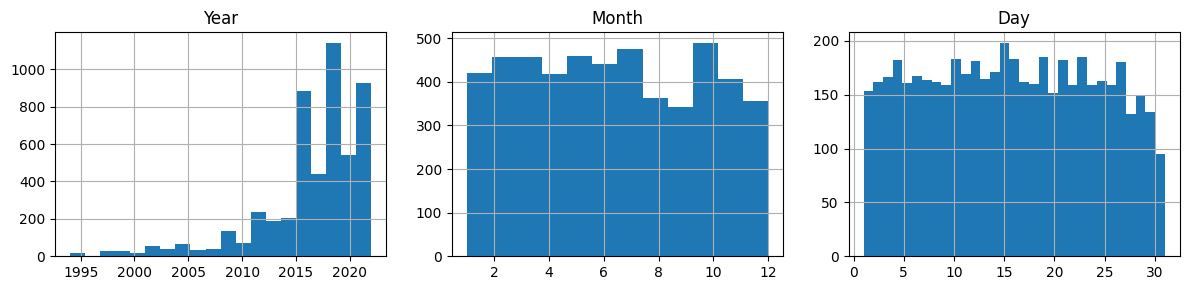

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))
trainset['year'].hist(bins=20, ax=axes[0])
axes[0].set_title('Year')

trainset['month'].hist(bins=12, ax=axes[1])
axes[1].set_title('Month')

trainset['day'].hist(bins=31, ax=axes[2])
axes[2].set_title('Day')
plt.tight_layout()
plt.show()

In [6]:
def print_plot_column(incidents:pd.DataFrame, column:str, ax = None, num_examples:int=10):
    value_counts = incidents[column].value_counts()
    values = value_counts.index
    counts = value_counts.values

    num_values = len(counts)

    print(f'\nColumn "{column}" (n = {num_values:d}):')
    if num_values > num_examples:
        t_values = np.concatenate([values[:num_examples//2], values[-num_examples//2:]])
        t_counts = np.concatenate([counts[:num_examples//2], counts[-num_examples//2:]])
        for v, n in zip(t_values, t_counts):
            print(f'  {v}:{" "*(50-len(v))}{n:5d}')
    else:
        for v, n in zip(values, counts):
            print(f'  {v}:{" "*(50-len(v))}{n:5d}')

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    if num_values > 20:
        num_values = 20
        values = np.array(list(values[:10]) + list(values[-10:]))
        counts = np.array(list(counts[:10]) + list(counts[-10:]))

    ax.bar(range(num_values), counts)
#    ax.set_ylabel('Count')

    if num_values <= 25:
        ax.set_xticks(range(num_values), values, rotation=90)
    else:
      ax.set_xticks([], [], rotation=90)


Column "hazard-category" (n = 10):
  allergens:                                          1854
  biological:                                         1741
  foreign bodies:                                      561
  fraud:                                               371
  chemical:                                            287
  other hazard:                                        134
  packaging defect:                                     54
  organoleptic aspects:                                 53
  food additives and flavourings:                       24
  migration:                                             3

Column "product-category" (n = 22):
  meat, egg and dairy products:                       1434
  cereals and bakery products:                         671
  fruits and vegetables:                               535
  prepared dishes and snacks:                          469
  seafood:                                             268
  food additives and flavourings:         

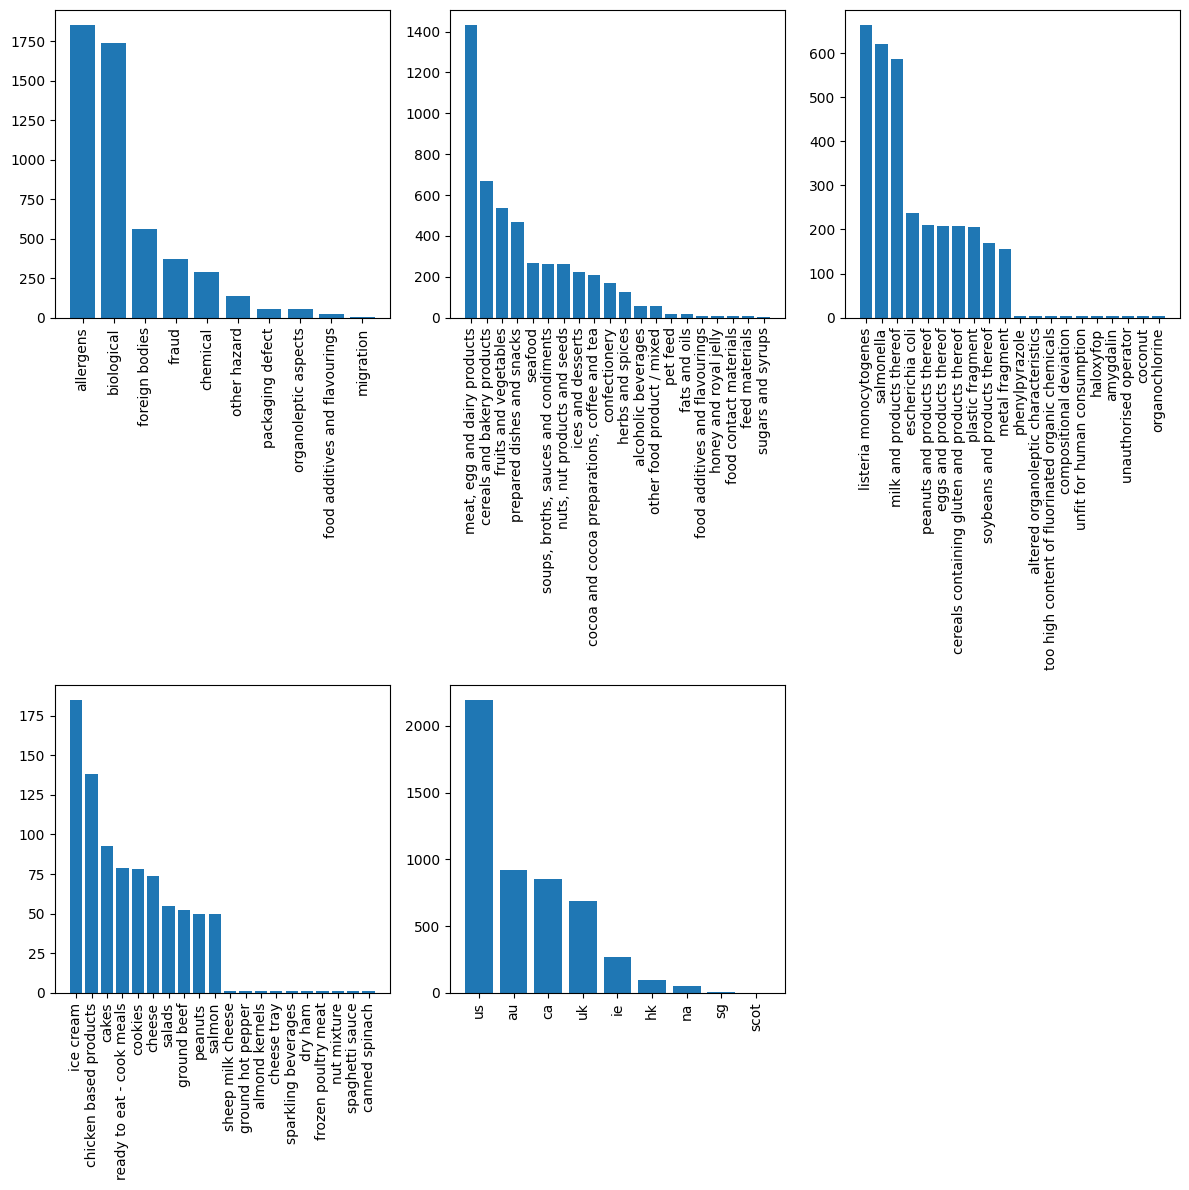

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))
print_plot_column(trainset, 'hazard-category',ax=axes[0,0])
print_plot_column(trainset, 'product-category',ax=axes[0,1])
print_plot_column(trainset, 'hazard',ax=axes[0,2])
print_plot_column(trainset, 'product',ax=axes[1,0])
print_plot_column(trainset, 'country',ax=axes[1,1])
fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

### Preprocessing dataset

In [8]:
def combine_input_text(dataset, text_columns):
    """ text_columns to be tokenizeed, such as 'title' or ['title', 'text'] or
        {'columns': ['title', 'text'], 'separator': ' [SEP] '} or {'columns': ['title', 'text'], 'format': 'Title: {title} Content: {text}'}"""

        # Handle different text_columns input types
    if isinstance(text_columns, str):  # Single column
        dataset['combined_text'] = dataset[text_columns]

    elif isinstance(text_columns, list): # Multiple columns - simple concatenation
        dataset['combined_text'] = dataset[text_columns].astype(str).agg(' '.join, axis=1)

    elif isinstance(text_columns, dict):   # Advanced options with custom formatting
        columns = text_columns.get('columns', [])
        separator = text_columns.get('separator', ' ')
        format_template = text_columns.get('format', None)

        if format_template:  # Custom format like "Title: {title} Content: {text}""
            dataset['combined_text'] = dataset.apply(
                lambda row: format_template.format(**{col: row[col] for col in columns}),
                axis=1
            )
        else:  # Simple join with separator
            dataset['combined_text'] = dataset[columns].astype(str).agg(separator.join, axis=1)

    return dataset[['combined_text'] + labels]

In [9]:
# Remove all records whose value is not in trainset
# For each label column, create a boolean mask where values of validset are in trainset's column
mask = True
for label_column in labels:
    mask = mask & validset[label_column].isin(trainset[label_column].unique())
# Keep only rows where validset exist in df2 for atrainset columns
validset = validset[mask].reset_index(drop=True)

# Remove all records whose value is not in trainset
# For each label column, create a boolean mask where values of validset are in trainset's column
mask = True
for label_column in labels:
    mask = mask & testset[label_column].isin(trainset[label_column].unique())
# Keep only rows where testset exist in df2 for atrainset columns
testset = testset[mask].reset_index(drop=True)

trainset = combine_input_text(trainset, text_columns)
validset = combine_input_text(validset, text_columns)
testset  = combine_input_text(testset, text_columns)

# trainset.head(2)

print('Number of training samples: ', len(trainset), ' validation samples: ', len(validset), ' test samples: ', len(testset))
print('Column Name:\n', list(trainset.columns))
trainset.head(5)

word_counts = trainset['combined_text'].apply(lambda x: len(str(x).split()))
print(word_counts.describe())

Number of training samples:  5082  validation samples:  516  test samples:  913
Column Name:
 ['combined_text', 'product', 'hazard', 'hazard-category', 'product-category']
count    5082.000000
mean       13.282369
std         5.229355
min         1.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        44.000000
Name: combined_text, dtype: float64


### Performance metric function

In [10]:
def compute_score(hazards_true, products_true, hazards_pred, products_pred):
    # compute f1 for hazards:
    f1_hazards = f1_score(
      hazards_true,
      hazards_pred,
      average='macro'
    )

    # compute f1 for products:
    f1_products = f1_score(
      products_true[hazards_pred == hazards_true],
      products_pred[hazards_pred == hazards_true],
      average='macro'
    )

    return (f1_hazards + f1_products) / 2

#### Confusion Matrix

In [11]:
def plot_least_frequent_confusion_matrix(y_true, y_pred, label_count=8, title='Confusion Matrix'):
    # Plots a confusion matrix for the N least frequent true classes.

    # Compute label frequency
    label_freq = pd.Series(y_true).value_counts()

    # Handle case where label_count > number of labels
    num_labels = len(label_freq)
    if label_count > num_labels:
        label_count = num_labels

    # Get the least frequent class labels from true labels
    least_common_classes = label_freq.nsmallest(label_count).index.tolist()
    
    # Filter y_true and y_pred to include only the least common classes
    y_true_series = pd.Series(y_true)
    y_pred_series = pd.Series(y_pred)

    mask = y_true_series.isin(least_common_classes)
    y_true_filtered = y_true_series[mask]
    y_pred_filtered = y_pred_series[mask]
    
    #  Generate confusion matrix
    cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=least_common_classes)
    
    # Plot the matrix
    cm_df = pd.DataFrame(cm, index=least_common_classes, columns=least_common_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.tight_layout()
    plt.show()

### Benchmark

PRODUCT
    Number of classes: 1022


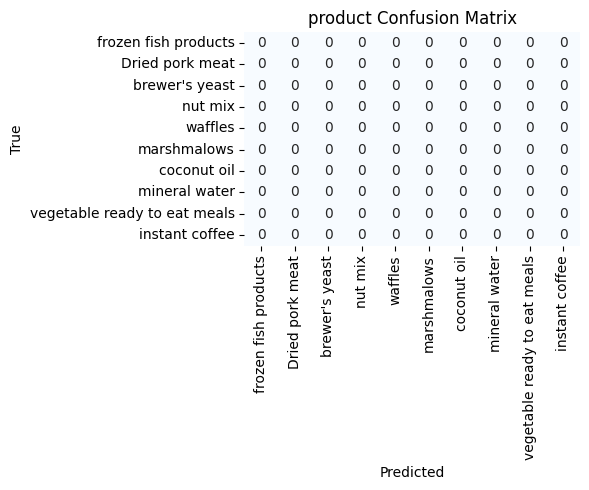

    Accuracy: 0.33 | macro: 0.10 | micro: 0.33
HAZARD
    Number of classes: 128


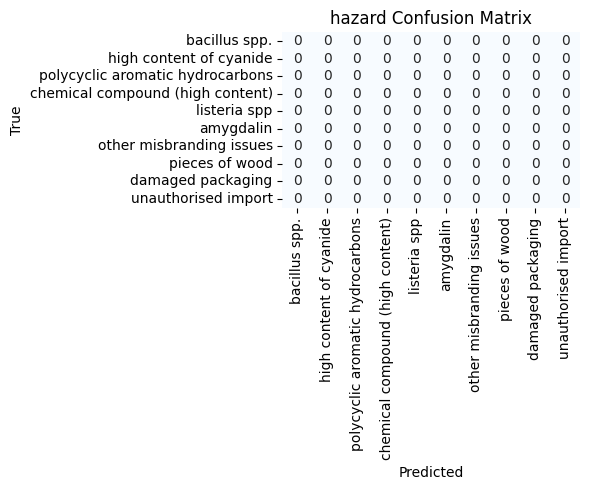

    Accuracy: 0.56 | macro: 0.16 | micro: 0.56
HAZARD-CATEGORY
    Number of classes: 10


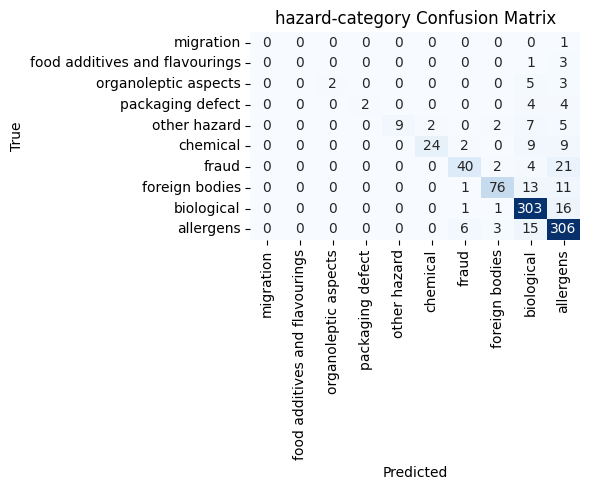

    Accuracy: 0.83 | macro: 0.51 | micro: 0.83
PRODUCT-CATEGORY
    Number of classes: 22


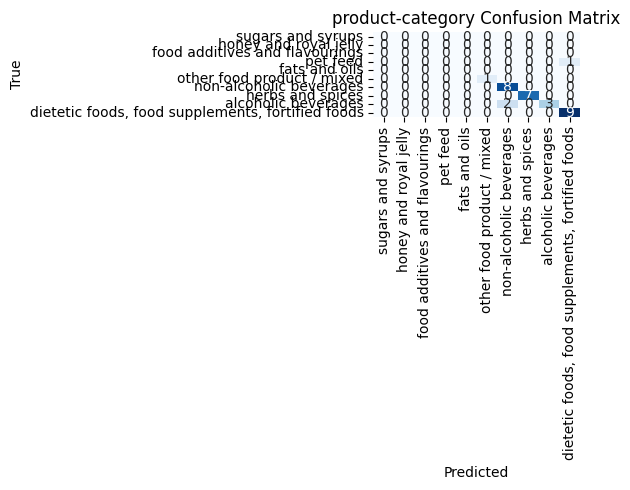

    Accuracy: 0.72 | macro: 0.47 | micro: 0.72

------ Benchmark Performance Results -------
Score Sub-Task 1: 0.490
Score Sub-Task 2: 0.140


In [12]:
if benchmark_enable and (not test_only):
    text_clf_lr = Pipeline([
        ('vect', TfidfVectorizer(strip_accents='unicode', analyzer='char', ngram_range=(2,5), max_df=0.5, min_df=5)),
        ('clf', LogisticRegression(max_iter=1000)),
    ])

    test_true = {}
    test_pred = {}
    for label_column in labels:
        print(label_column.upper())

        label_encoder = LabelEncoder()
        label_encoder.fit(trainset[label_column])
        print(f'    Number of classes: {len(label_encoder.classes_)}')

        X_train = trainset['combined_text']
        y_train = label_encoder.transform(trainset[label_column])

        text_clf_lr.fit(X_train, y_train)

        # calculate scores using test dataset
        y_pred = text_clf_lr.predict(testset['combined_text'])

        test_true[label_column] = testset[label_column]
        test_pred[label_column] = label_encoder.inverse_transform(y_pred)

        accuracy = accuracy_score(test_true[label_column], test_pred[label_column])
        f1_marco = f1_score(test_true[label_column], test_pred[label_column], zero_division=0, average="macro")
        f1_mirco = f1_score(test_true[label_column], test_pred[label_column], zero_division=0, average="micro")

        plot_least_frequent_confusion_matrix(test_true[label_column], test_pred[label_column], label_count=10, title=label_column + ' Confusion Matrix')

        print(f'    Accuracy: {accuracy:.2f} | macro: {f1_marco:.2f} | micro: {f1_mirco:.2f}')

    ST1_score = compute_score(np.array(test_true['hazard-category']), np.array(test_true['product-category']),
                            np.array(test_pred['hazard-category']), np.array(test_pred['product-category']))
    ST2_score = compute_score(np.array(test_true['hazard']), np.array(test_true['product']),
                            np.array(test_pred['hazard']), np.array(test_pred['product']))

    print("")
    print(f"------ Benchmark Performance Results -------")
    print(f"Score Sub-Task 1: {ST1_score:.3f}")
    print(f"Score Sub-Task 2: {ST2_score:.3f}")

#### Generate dataloader

In [13]:
def tokenization(dataset, tokenizer, max_length=64):
    # Convert to HF Dataset

    hf_dataset = Dataset.from_pandas(dataset[['combined_text', 'label']])
    # print(hf_dataset)

    def tokenize_function(examples):
        return tokenizer(
            examples["combined_text"],
            truncation=True,
            padding=False,
            max_length=max_length
        )

    token_dataset = hf_dataset.map(tokenize_function, batched=True, desc=None)  # desc controls the progress display
    token_dataset = token_dataset.remove_columns(["combined_text"])
    # print(token_dataset)

    return token_dataset

def generate_dataloader(dataset, label_column, label_encoder, tokenizer, train_flag=False):

    # print(dataset.columns.tolist())
    dataset_copy = dataset.copy()
    dataset_copy['label'] = label_encoder.transform(dataset[label_column])
    # print(dataset_copy.columns.tolist())

    if 'token_dataset' in (locals() or globals()):
        del token_dataset

    token_dataset = tokenization(dataset_copy, tokenizer, max_length=512)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

    if train_flag == True:
        if balanced_sample_enable:
            def create_balanced_sampler(labels, num_classes):
                # Ensure weights cover all classes
                class_counts = np.bincount(labels, minlength=num_classes)

                # Calculate weights
                weights = len(labels) / (num_classes * class_counts)

                # Create sample weights for each label
                sample_weights = torch.tensor([weights[label] for label in labels])

                return WeightedRandomSampler(
                    weights=sample_weights,
                    num_samples=len(labels),
                    replacement=True
                )

            # When creating sampler
            num_classes = len(np.unique(token_dataset['label']))
            sampler = create_balanced_sampler(token_dataset['label'], num_classes)

            dataloader = DataLoader(token_dataset, sampler=sampler, batch_size=16, collate_fn=data_collator)
        else:
            dataloader = DataLoader(token_dataset, shuffle=True, batch_size=16, collate_fn=data_collator)

    else:
        dataloader = DataLoader(token_dataset, shuffle=False, batch_size=16, collate_fn=data_collator)

    return dataloader

#### Model evaluation function

In [14]:
def evaluate_model(model, valid_dataloader, label_encoder, verbose =4):
    # get the device (CPU or GPU) that the model is currently on.
    device = next(model.parameters()).device

    # set model to evaluation mode
    model.eval()

    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(valid_dataloader, desc=f"validation evaluation", disable=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted',zero_division=0)

    # Convert predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(predictions)
    gold_labels = label_encoder.inverse_transform(true_labels)

    if verbose > 0:
        # Print results
        print(f'\tEvaluation Result -- Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')
    if verbose > 1:
        print("\tClassification Report:")
        print(classification_report(gold_labels, predicted_labels, zero_division=0))

    return true_labels, predictions

#### Function of model training with evaluation

In [15]:
def train_model(model, train_dataloader, label_encoder, num_epochs=3, learning_rate=2e-5,
                valid_dataloader=None, verbose=4):

    true_labels = None
    predictions = None

    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Add before training loop
    if class_weight_enable:
        data_label = train_dataloader.dataset['label']
        num_classes = len(label_encoder.classes_)
        class_weights = torch.zeros(num_classes, dtype=torch.float)
        unique_labels, counts = np.unique(data_label, return_counts=True)
        weights = len(data_label) / (num_classes * counts)
        class_weights[unique_labels] = torch.tensor(weights, dtype=torch.float)

     # Training loop
    for epoch in range(num_epochs):
        model.train()

        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}",  disable=False):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss

            if class_weight_enable:
                # Modify loss calculation for imbalanced dataset
                criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
                loss = criterion(outputs.logits, labels)
            else:
                loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        if verbose > 0:
            print(f'\tEpoch {epoch+1}/{num_epochs}, Average Training Loss: {total_loss/len(train_dataloader):.4f}')

        if valid_dataloader is not None:
            # Evaluate performance using validset
            true_labels, predictions = evaluate_model(model, valid_dataloader, label_encoder, verbose)

    return true_labels, predictions

#### Training model

In [16]:
if not test_only:

    if model_name == "roberta-base":
        tokenizer = RobertaTokenizer.from_pretrained(model_name, disable_tqdm=True)
    else:
        raise ValueError(f"The {model_name} is not supported!")

    tokenizer_save_path = os.path.join(root_path, 'Models', f'{model_name}_tokenizer')
    tokenizer.save_pretrained(tokenizer_save_path)

    valid_true = {}
    valid_pred = {}
    for label_column in labels:
        print(f'\n{label_column.upper()}')

        label_encoder = LabelEncoder()
        label_encoder.fit(trainset[label_column])
        print(f'    Number of classes: {len(label_encoder.classes_)}')

        valid_dataloader = generate_dataloader(validset, label_column, label_encoder, tokenizer, train_flag=False)
        train_dataloader = generate_dataloader(trainset, label_column, label_encoder, tokenizer, train_flag=True)

        if model_name == "roberta-base":
            warnings.filterwarnings("ignore", message="Some weights of RobertaForSequenceClassification")
            # Dynamically create the model variable name
            model_variable_name = f"model_{label_column.replace('-', '_')}"
            exec(f"{model_variable_name} = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=len(trainset[label_column].unique()))")
        else:
            raise ValueError(f"The {model_name} is not supported!")

        # Get the dynamically created model
        model = eval(model_variable_name)

        if verbose > 2:
            print(model)

        valid_true[label_column], valid_pred[label_column] = train_model(model, train_dataloader, label_encoder,
                    num_epochs=num_epochs, learning_rate=2e-5, valid_dataloader=valid_dataloader, verbose=verbose)

        # Update the save path to reflect the new variable name and structure
        model_save_path = os.path.join(root_path, 'Models', f'{model_name}_{label_column}')
        model.save_pretrained(model_save_path)
        np.save(os.path.join(model_save_path, 'label_encoder.npy'), label_encoder.classes_)

        model.cpu()                  # Move model to CPU (optional, safer)
        del model                    # Delete model reference
        torch.cuda.empty_cache()     # Clear cached GPU memory
        gc.collect()
        print('-'*50)

    ST1_score = compute_score(np.array(valid_true['hazard-category']), np.array(valid_true['product-category']),
                            np.array(valid_pred['hazard-category']), np.array(valid_pred['product-category']))
    ST2_score = compute_score(np.array(valid_true['hazard']), np.array(valid_true['product']),
                            np.array(valid_pred['hazard']), np.array(valid_pred['product']))
    print("")
    print(f"------ Validation Performance Results -------")
    print(f"Score Sub-Task 1: {ST1_score:.3f}")
    print(f"Score Sub-Task 2: {ST2_score:.3f}")



PRODUCT
    Number of classes: 1022


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 95.32it/s]


--------------------------------------------------

HAZARD
    Number of classes: 128


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 95.36it/s]


--------------------------------------------------

HAZARD-CATEGORY
    Number of classes: 10


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 95.31it/s]


--------------------------------------------------

PRODUCT-CATEGORY
    Number of classes: 22


Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/5082 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
validation evaluation: 100%|██████████| 33/33 [00:00<00:00, 95.40it/s]


--------------------------------------------------

------ Validation Performance Results -------
Score Sub-Task 1: 0.744
Score Sub-Task 2: 0.426


### BERT Predict

#### Predict function

In [17]:
def predict(model, test_dataloader):
    # Move model to GPU if available
    model.to(device)

    model.eval()

    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc=f"prediction"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels


#### Model predict and performance analysis


PRODUCT


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

prediction: 100%|██████████| 58/58 [00:00<00:00, 92.91it/s]


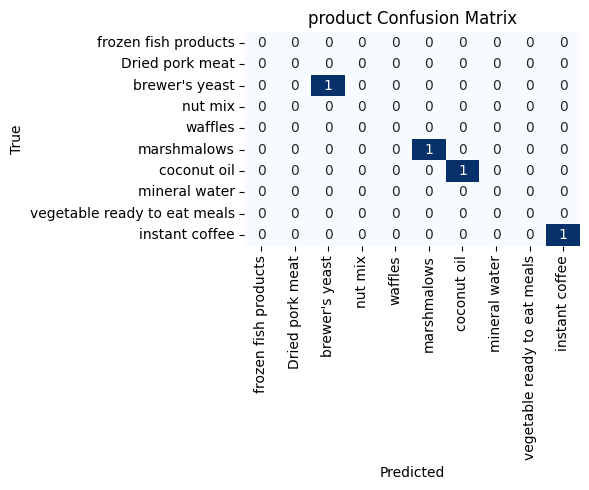

--------------------------------------------------

HAZARD


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

prediction: 100%|██████████| 58/58 [00:00<00:00, 94.45it/s]


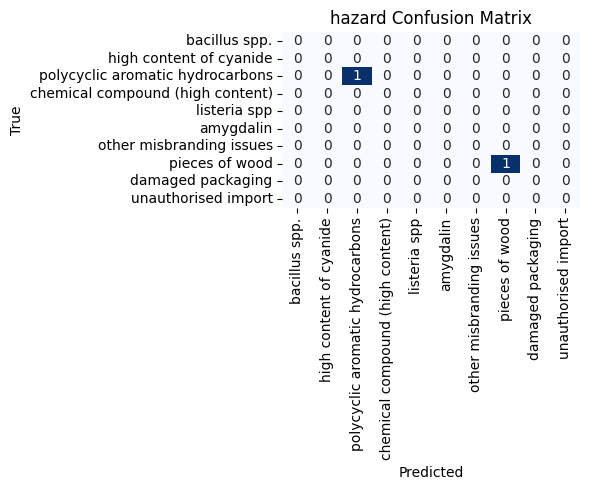

--------------------------------------------------

HAZARD-CATEGORY


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

prediction: 100%|██████████| 58/58 [00:00<00:00, 94.16it/s]


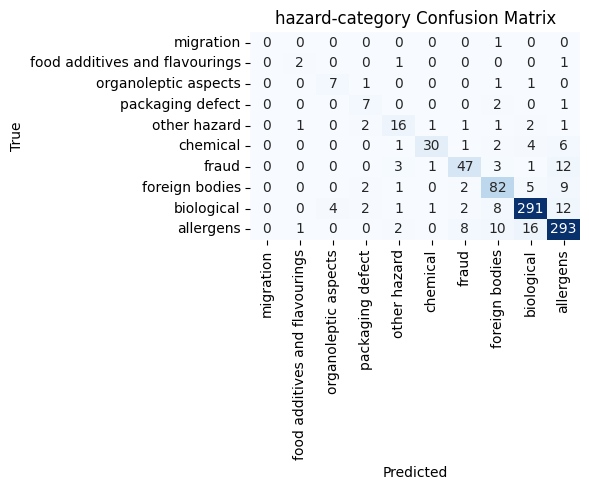

--------------------------------------------------

PRODUCT-CATEGORY


Map:   0%|          | 0/913 [00:00<?, ? examples/s]

prediction: 100%|██████████| 58/58 [00:00<00:00, 94.55it/s]


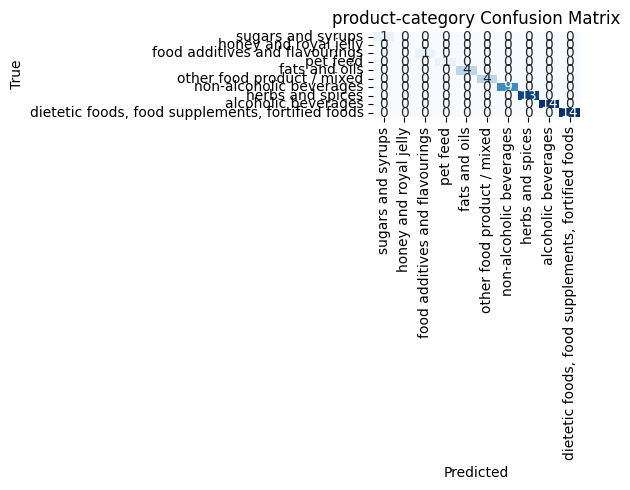

--------------------------------------------------

------ Test Performance Results -------
Score Sub-Task 1: 0.673
Score Sub-Task 2: 0.431


In [18]:
model_folder_name = 'Models'

tokenizer_save_path = os.path.join(root_path, model_folder_name, f'{model_name}_tokenizer')
if model_name == "roberta-base":
    tokenizer = RobertaTokenizer.from_pretrained(tokenizer_save_path)
else:
    raise ValueError(f"The {model_name} is not supported!")

test_true = {}
test_pred = {}
for label_column in labels:
    print(f'\n{label_column.upper()}')
    # Load model
    model_save_path = os.path.join(root_path, model_folder_name, f'{model_name}_{label_column}')

    # Dynamically create the model variable name
    model_variable_name = f"model_{label_column.replace('-', '_')}"
    exec(f"{model_variable_name} = RobertaForSequenceClassification.from_pretrained(model_save_path)")

    # Get the dynamically created model
    model = eval(model_variable_name)

    if verbose > 2:
        print(model)

    # Load label encoder
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.load(os.path.join(model_save_path, 'label_encoder.npy'),allow_pickle=True)

    test_dataloader = generate_dataloader(testset, label_column, label_encoder, tokenizer, train_flag=False)

    test_pred[label_column], test_true[label_column] = predict(model, test_dataloader)

    # Calculate metrics
    accuracy = accuracy_score(test_true[label_column] , test_pred[label_column])
    precision, recall, f1, _ = precision_recall_fscore_support(test_true[label_column] , test_pred[label_column], average='weighted',zero_division=0)

    # Convert predictions back to original labels
    predicted_labels = label_encoder.inverse_transform(test_pred[label_column])
    true_labels = label_encoder.inverse_transform(test_true[label_column] )

    plot_least_frequent_confusion_matrix(true_labels, predicted_labels, label_count=10, title=label_column + ' Confusion Matrix')
    
    if verbose > 0:
        # Print results
        print(f'\tEvaluation Result -- Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')

    if verbose > 1:
        print("\tClassification Report:")
        print(classification_report(true_labels, predicted_labels, zero_division=0))

    print('-'*50)

ST1_score = compute_score(np.array(test_true['hazard-category']), np.array(test_true['product-category']),
                        np.array(test_pred['hazard-category']), np.array(test_pred['product-category']))
ST2_score = compute_score(np.array(test_true['hazard']), np.array(test_true['product']),
                        np.array(test_pred['hazard']), np.array(test_pred['product']))
print("")
print(f"------ Test Performance Results -------")
print(f"Score Sub-Task 1: {ST1_score:.3f}")
print(f"Score Sub-Task 2: {ST2_score:.3f}")
